In [1]:
from torchvision import datasets, transforms
import torch
import lightning as L
from lightning.pytorch.callbacks import ModelCheckpoint
from torch.utils.data import random_split, DataLoader
import matplotlib.pyplot as plt

from cnn_model import CNNModel
from vit_model import ViTModel

/home/yanis/paris_cite/S2/TER/model_training/venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# we'll see if needed
# Define transforms to preprocess the data (you can customize these as needed)
TARGET_WIDTH = 224
TARGET_HEIGHT = 224

transform = transforms.Compose([
    transforms.ToTensor(),              # Convert the image to a PyTorch tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),  # Normalize the image
    #transforms.Pad((111, 96, 112, 96), fill=0),  # Add Padding:  Our images are 64x33 (left,right,top, bottom)
    transforms.Pad((95,80, 95, 80), fill=0) # Add padding for ViT (target is 224*224)
])

In [3]:
# Load the dataset using ImageFolder
train_dataset = datasets.ImageFolder(root="dataset/train", transform=transform)
eval_dataset = datasets.ImageFolder(root="dataset/eval", transform=transform)
test_dataset = datasets.ImageFolder(root="dataset/test", transform=transform)
train_dataset.class_to_idx, eval_dataset.class_to_idx, test_dataset.class_to_idx

({'holo': 0, 'non-holo': 1},
 {'holo': 0, 'non-holo': 1},
 {'holo': 0, 'non-holo': 1})

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


label : holo


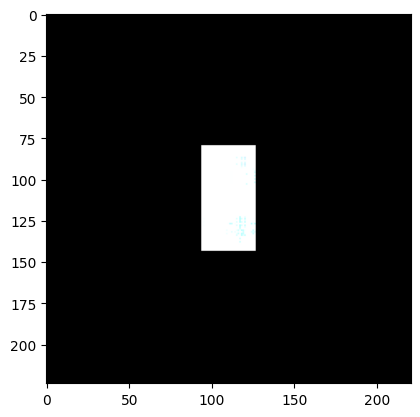

In [4]:
image_index = 0
plt.imshow(train_dataset[image_index][0].permute(1, 2, 0))
print(f"label : {train_dataset.classes[train_dataset[image_index][1]]}")
#Normalization will cause the colors to be off or to be impossible to read by imshow

In [5]:
train_dataset[0][0]

tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]],

        [[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]],

        [[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]])

In [6]:
# Define DataLoader for each split using the respective sampler
training_dataloader = DataLoader(train_dataset, batch_size=128, shuffle=True )
validation_dataloader = DataLoader(eval_dataset, batch_size=128, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=128, shuffle=True)

In [7]:
len(train_dataset), len(eval_dataset), len(test_dataset)

(24000, 3000, 3000)

In [8]:
#model = CNNModel(num_classes=1,
#                 lr=0.0001)
model = ViTModel(num_classes=1,
                 lr=0.0001)

/home/yanis/paris_cite/S2/TER/model_training/venv/lib/python3.12/site-packages/timm/models/_factory.py:117: UserWarning: Mapping deprecated model name vit_tiny_patch16_224_in21k to current vit_tiny_patch16_224.augreg_in21k.
  model = create_fn(


In [9]:
model

ViTModel(
  (pretrained_ViT): VisionTransformer(
    (patch_embed): PatchEmbed(
      (proj): Conv2d(3, 192, kernel_size=(16, 16), stride=(16, 16))
      (norm): Identity()
    )
    (pos_drop): Dropout(p=0.0, inplace=False)
    (patch_drop): Identity()
    (norm_pre): Identity()
    (blocks): Sequential(
      (0): Block(
        (norm1): LayerNorm((192,), eps=1e-06, elementwise_affine=True)
        (attn): Attention(
          (qkv): Linear(in_features=192, out_features=576, bias=True)
          (q_norm): Identity()
          (k_norm): Identity()
          (attn_drop): Dropout(p=0.0, inplace=False)
          (proj): Linear(in_features=192, out_features=192, bias=True)
          (proj_drop): Dropout(p=0.0, inplace=False)
        )
        (ls1): Identity()
        (drop_path1): Identity()
        (norm2): LayerNorm((192,), eps=1e-06, elementwise_affine=True)
        (mlp): Mlp(
          (fc1): Linear(in_features=192, out_features=768, bias=True)
          (act): GELU(approximate='non

In [10]:
checkpoint_callback = ModelCheckpoint(
        dirpath="models",
        monitor="validation_accuracy",
        filename="best",
        mode="max",
        save_last=True,
        verbose=True
    )
# train the model (hint: here are some helpful Trainer arguments for rapid idea iteration)
trainer = L.Trainer(max_epochs=30,
                    log_every_n_steps=1,
                    val_check_interval=0.25,
                    callbacks=[checkpoint_callback])

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [11]:
trainer.fit(model=model, train_dataloaders=training_dataloader, val_dataloaders=validation_dataloader)

You are using a CUDA device ('NVIDIA GeForce RTX 4060 Laptop GPU') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
/home/yanis/paris_cite/S2/TER/model_training/venv/lib/python3.12/site-packages/lightning/pytorch/callbacks/model_checkpoint.py:653: Checkpoint directory /home/yanis/paris_cite/S2/TER/model_training/models exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type              | Params
------------------------------------------------------
0 | pretrained_ViT  | VisionTransformer | 5.5 M 
1 | accuracy_metric | BinaryAccuracy    | 0     
------------------------------------------------------
5.5 M     Trainable params
0         Non-trainable params
5.5 M     Total params
22.098    Tota

Sanity Checking DataLoader 0:   0%|          | 0/2 [00:00<?, ?it/s]

/home/yanis/paris_cite/S2/TER/model_training/venv/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:492: Your `val_dataloader`'s sampler has shuffling enabled, it is strongly recommended that you turn shuffling off for val/test dataloaders.
/home/yanis/paris_cite/S2/TER/model_training/venv/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.


AssertionError: Input width (221) doesn't match model (224).

In [ ]:
#print(f"Loading model best.ckpt")
#best_model = CNNModel.load_from_checkpoint("models/best.ckpt", num_classes=1, lr=0.0001).to('cuda')
#best_model

In [ ]:
print(f"Loading model best.ckpt")
best_model = ViTModel.load_from_checkpoint("models/best-v1.ckpt", num_classes=1, lr=0.0001).to('cuda')
best_model

Loading model best.ckpt


ViTModel(
  (pretrained_ViT): VisionTransformer(
    (patch_embed): PatchEmbed(
      (proj): Conv2d(3, 192, kernel_size=(16, 16), stride=(16, 16))
      (norm): Identity()
    )
    (pos_drop): Dropout(p=0.0, inplace=False)
    (patch_drop): Identity()
    (norm_pre): Identity()
    (blocks): Sequential(
      (0): Block(
        (norm1): LayerNorm((192,), eps=1e-06, elementwise_affine=True)
        (attn): Attention(
          (qkv): Linear(in_features=192, out_features=576, bias=True)
          (q_norm): Identity()
          (k_norm): Identity()
          (attn_drop): Dropout(p=0.0, inplace=False)
          (proj): Linear(in_features=192, out_features=192, bias=True)
          (proj_drop): Dropout(p=0.0, inplace=False)
        )
        (ls1): Identity()
        (drop_path1): Identity()
        (norm2): LayerNorm((192,), eps=1e-06, elementwise_affine=True)
        (mlp): Mlp(
          (fc1): Linear(in_features=192, out_features=768, bias=True)
          (act): GELU(approximate='non

In [ ]:
trainer.test(model=best_model, dataloaders=test_dataloader)

You are using a CUDA device ('NVIDIA GeForce RTX 4060 Laptop GPU') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/yanis/paris_cite/S2/TER/model_training/venv/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:492: Your `test_dataloader`'s sampler has shuffling enabled, it is strongly recommended that you turn shuffling off for val/test dataloaders.
/home/yanis/paris_cite/S2/TER/model_training/venv/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.


Testing DataLoader 0:   0%|          | 0/24 [00:00<?, ?it/s]

/home/yanis/paris_cite/S2/TER/model_training/venv/lib/python3.12/site-packages/torch/nn/modules/conv.py:456: UserWarning: Applied workaround for CuDNN issue, install nvrtc.so (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:80.)
  return F.conv2d(input, weight, bias, self.stride,


Testing DataLoader 0: 100%|██████████| 24/24 [00:04<00:00,  5.81it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
      test_accuracy         0.8569999933242798
        test_loss           0.33718156814575195
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test_loss': 0.33718156814575195, 'test_accuracy': 0.8569999933242798}]

In [25]:
input, label = next(iter(test_dataloader))

In [26]:
input = input.to('cuda')
input.shape

torch.Size([128, 3, 224, 224])

In [27]:
label = label.to('cuda')
label.shape

torch.Size([128])

In [28]:
# For every INPUT_SIZE / Prediction size do the prediction then append
best_model.eval()
with torch.no_grad():
        #input = input.unsqueeze(0).to('cpu')
        #print(input)
        y_hat = best_model(input).squeeze()
        result = torch.nn.functional.sigmoid(y_hat)
# Output the last 100 of the result

In [29]:
result

tensor([0.9351, 0.9714, 0.3627, 0.1418, 0.5261, 0.9647, 0.6980, 0.4075, 0.7207,
        0.5179, 0.0435, 0.5058, 0.0073, 0.9472, 0.8690, 0.5513, 0.9751, 0.9591,
        0.6555, 0.8751, 0.8892, 0.6918, 0.4900, 0.0498, 0.7538, 0.9683, 0.6867,
        0.9061, 0.9249, 0.9157, 0.1855, 0.7719, 0.9694, 0.7420, 0.9255, 0.0397,
        0.7750, 0.8253, 0.6235, 0.6668, 0.6615, 0.2057, 0.2617, 0.0080, 0.8687,
        0.9533, 0.3209, 0.0161, 0.0356, 0.0656, 0.9721, 0.9669, 0.2779, 0.8716,
        0.9646, 0.3607, 0.9113, 0.9637, 0.9039, 0.7049, 0.5602, 0.6361, 0.0273,
        0.9400, 0.2535, 0.7930, 0.0390, 0.8970, 0.9526, 0.9416, 0.4072, 0.0072,
        0.0093, 0.3741, 0.9503, 0.3566, 0.8670, 0.3487, 0.1036, 0.4163, 0.9888,
        0.9069, 0.7401, 0.0678, 0.9539, 0.4978, 0.8160, 0.9348, 0.8016, 0.9649,
        0.9311, 0.2102, 0.9488, 0.0719, 0.9170, 0.8647, 0.8692, 0.5067, 0.3115,
        0.0758, 0.9592, 0.4297, 0.9075, 0.0162, 0.2135, 0.7954, 0.1990, 0.0786,
        0.0626, 0.7620, 0.0085, 0.0726, 

In [30]:
label

tensor([1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0,
        1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0,
        0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0,
        0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1,
        1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1,
        1, 0, 0, 1, 0, 1, 1, 0], device='cuda:0')